In [ ]:
import pandas as pd
import geopandas as gpd
import duckdb
import rasterstats

In [64]:
import holoviews as hv

In [65]:
hv.help(hv.Rectangles)

Parameters of 'Rectangles'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                        Value                     Type     Bounds   Mode 

group                    'Rectangles'                String             C RW 
label                         ''                     String             C RW 
cdims                         {}                      Dict              V RW 
kdims      [Dimension('x0'), Dimension('y0'), Di...   List     (4, 4)   C RW 
vdims                         []                      List   (0, None)  C RW 
extents            (None, None, None, None)          Tuple              V RW 
datatype   ['dataframe', 'dictionary', 'grid', '...   List   (0, None)  V RW 

Parameter docstrings:

group:    A string describing the data wrapped by the object.
label:    Optional label describing the data, typically reflecting where
          or how it

In [ ]:
bankies = gpd.read_file(r"p:\2022\Albany\21250022_070_Embankment Breach Modeling and Risk Assessment (Att. B)\03-SEProducts\02-Calcs\06-HazardClassification\00-EmbankmentScreening\Schnabel_Embankments_17MP_DRAFT_plm.shp")

In [ ]:
orig_bankies = bankies.copy()

In [ ]:
orig_bankies

In [ ]:
bankies = bankies.set_geometry(bankies.extract_unique_points()).explode()

In [ ]:
bankies['milepost'] = bankies.geometry.z

In [ ]:
bankies = bankies.set_geometry(bankies.force_2d())

In [ ]:
bankies = bankies.to_crs(6535)

In [ ]:
bankies['z'] = list(rasterstats.gen_point_query(bankies, r'c:\Users\talbanese\Downloads\17-Mile Pool\17-MileLiDAR_No_Bathy.tif'))

In [69]:
bankies.drop('geometry', axis=1).to_csv(r'data\all_embankment_points.csv')

In [52]:
bankies.groupby('InterimNam', as_index=False).min(numeric_only=True).merge(orig_bankies[['InterimNam', 'Side']], on='InterimNam').to_csv(r'data\embankment_z.csv', index=False)

In [75]:
DATA_DIR = r"C:/Users/talbanese/OneDrive - Schnabel Engineering Inc/Documents/python_projects/time_series_plots/data/parquet"
BANKIES = r'C:/Users/talbanese/OneDrive - Schnabel Engineering Inc/Documents/python_projects/time_series_bokeh/data/embankment_z.csv'
BANKIE_POINTS = r'data\all_embankment_points.csv'
CON = duckdb.connect(database=":memory:")

CON.execute(
    f"""CREATE TABLE wse AS
    SELECT  ROW_NUMBER() OVER () AS row_number, * FROM '{DATA_DIR +"/*.parquet"}';"""
)
CON.execute(
    f"""CREATE TABLE banks AS
    SELECT InterimNam, Side, M_Start, M_End, z FROM '{BANKIES}';"""
)
CON.execute(
    f"""CREATE TABLE bank_points AS
    SELECT InterimNam, Side, Milepost, z FROM '{BANKIE_POINTS}';"""
)


CON.execute(
    """
ALTER TABLE wse
RENAME COLUMN "Plan Name" to plan_name
"""
)
CON.execute("""
CREATE TABLE overtops AS (
SELECT *
FROM wse
CROSS JOIN banks
WHERE wse.Milepost BETWEEN banks.M_Start AND banks.M_End 
      AND wse.WSE > banks.z
)
            
""")

In [78]:
CON.execute("""SELECT *
FROM bank_points""").fetch_df()

,InterimNam,Side,milepost,z
0,N_239.06_239.96,North,239.060074,464.108423
1,N_239.06_239.96,North,239.066330,464.526472
2,N_239.06_239.96,North,239.073135,465.096232
3,N_239.06_239.96,North,239.093811,466.333470
4,N_239.06_239.96,North,239.100006,466.334181
...,...,...,...,...
971,N_257.90_258.01,North,257.939575,516.113263
972,N_257.90_258.01,North,257.953278,516.157004
973,N_257.90_258.01,North,257.986725,516.290306
974,N_257.90_258.01,North,258.000000,516.388910


In [54]:
plan_name = 'RoG_PMP_E32_0.5xPMF'
timestep = '02JAN2024 13:20:00'

In [63]:
CON.execute(
    """SELECT 
            M_End,
            0,
            M_start,
            50,
            CASE WHEN InterimNam IN (SELECT InterimNam FROM overtops WHERE plan_name IN $plan_name AND Timestep =$Timestep) THEN 'red' ELSE 'green' END AS color
            FROM banks
            WHERE Side = 'North'
            """,
    {"plan_name": [plan_name], "timestep": timestep},
).fetchall()

[(239.060073853, 0, 238.964981079, 50, 'green'),
 (239.960174561, 0, 239.060073853, 50, 'green'),
 (240.787277222, 0, 239.996582031, 50, 'red'),
 (244.90536499, 0, 244.805999756, 50, 'red'),
 (245.400604248, 0, 245.391159058, 50, 'green'),
 (247.067901611, 0, 246.872756958, 50, 'green'),
 (247.45451355, 0, 247.38444519, 50, 'green'),
 (247.894638062, 0, 247.749420166, 50, 'green'),
 (249.109634399, 0, 247.971939087, 50, 'green'),
 (249.460281372, 0, 249.15335083, 50, 'green'),
 (249.810180664, 0, 249.493972778, 50, 'red'),
 (250.190887451, 0, 250.15234375, 50, 'green'),
 (250.545806885, 0, 250.29486084, 50, 'green'),
 (250.955093384, 0, 250.624893188, 50, 'red'),
 (251.516204834, 0, 250.961837769, 50, 'red'),
 (252.345901489, 0, 251.827911377, 50, 'green'),
 (252.440856934, 0, 252.377044678, 50, 'green'),
 (252.646835327, 0, 252.467254639, 50, 'red'),
 (253.010742188, 0, 252.98046875, 50, 'green'),
 (253.881744385, 0, 253.853530884, 50, 'green'),
 (254.779052734, 0, 254.15133667, 50, '

In [79]:
hv.help(hv.streams.Tap)

Parameters of 'Tap'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

NameValue       Type        Mode  

x   None  ClassSelector  C RW AN 
y   None  ClassSelector  C RW AN 

Parameter docstrings:

x: Pointer position along the x-axis in data coordinates
y: Pointer position along the y-axis in data coordinates


In [84]:
x= 269
closest_milepost = CON.execute("""
    SELECT Milepost
    FROM wse
    ORDER BY ABS(Milepost - $x)
    LIMIT 1
""", dict(x=x)).fetchall()[0][0]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
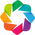

Help on method builder in module holoviews.util:

builder(
    *,
    active_tools,
    align,
    alpha,
    apply_extents,
    apply_hard_bounds,
    apply_ranges,
    aspect,
    autohide_toolbar,
    autorange,
    axiswise,
    backend,
    backend_opts,
    bgcolor,
    border,
    color,
    data_aspect,
    default_span,
    default_tools,
    fontscale,
    fontsize,
    frame_height,
    frame_width,
    framewise,
    gridstyle,
    height,
    hooks,
    hover_alpha,
    hover_color,
    hover_formatters,
    hover_line_alpha,
    hover_line_cap,
    hover_line_color,
    hover_line_dash,
    hover_line_dash_offset,
    hover_line_join,
    hover_line_width,
    hover_mode,
    hover_tooltips,
    interpolation,
    invert_axes,
    invert_xaxis,
    invert_yaxis,
    labelled,
    line_alpha,
    line_cap,
    line_color,
    line_dash,
    line_dash_offset,
    line_join,
    line_width,
    lod,
    logx,
    logy,
    margin,
    max_height,
    max_width,
    min_heigh

In [91]:
hv.extension('bokeh')
hv.help(hv.opts.Curve)

In [1]:
import polars as pl

In [18]:
precip_data_loc = r"C:\Users\talbanese\OneDrive - Schnabel Engineering Inc\Documents\python_projects\time_series_plots\data\to_plot\precip_data.csv"
precip_data = (
    pl.read_csv(
        precip_data_loc,
        schema_overrides={
            "Timestep": pl.String,
            "Rate": pl.Float32,
            "Storm": pl.String,
            "Unit": pl.String,
        },
    )
    .with_columns(
        pl.col("Timestep").str.to_datetime("%d %b %Y, %H:%M"),
    )
    .sort("Timestep")
    .with_columns(
        pl.col("Rate").shift(1).cum_sum().over("Storm").alias("Accumulation"),
    ).upsample("Timestep", every="10m")
)
partitions = precip_data.partition_by("Storm", include_key=True, as_dict=True)

for k, v in partitions.items():
    partitions[k] = v.upsample("Timestep", every="10m").with_columns(
        pl.col(["Rate", "Storm", "Unit"]).forward_fill(),
        pl.col("Accumulation").interpolate().fill_null(0),
    )

In [17]:
partitions

{('10_sqmi_0.5PMF',): shape: (457, 5)
 ┌─────────────────────┬─────────┬────────────────┬─────────────────┬──────────────┐
 │ Timestep            ┆ Rate    ┆ Storm          ┆ Unit            ┆ Accumulation │
 │ ---                 ┆ ---     ┆ ---            ┆ ---             ┆ ---          │
 │ datetime[μs]        ┆ f32     ┆ str            ┆ str             ┆ f32          │
 ╞═════════════════════╪═════════╪════════════════╪═════════════════╪══════════════╡
 │ 2023-12-31 20:00:00 ┆ 0.02145 ┆ 10_sqmi_0.5PMF ┆ Inches per Hour ┆ 0.0          │
 │ 2023-12-31 20:10:00 ┆ 0.02145 ┆ 10_sqmi_0.5PMF ┆ Inches per Hour ┆ 0.0          │
 │ 2023-12-31 20:20:00 ┆ 0.02145 ┆ 10_sqmi_0.5PMF ┆ Inches per Hour ┆ 0.0          │
 │ 2023-12-31 20:30:00 ┆ 0.02145 ┆ 10_sqmi_0.5PMF ┆ Inches per Hour ┆ 0.0          │
 │ 2023-12-31 20:40:00 ┆ 0.02145 ┆ 10_sqmi_0.5PMF ┆ Inches per Hour ┆ 0.0          │
 │ …                   ┆ …       ┆ …              ┆ …               ┆ …            │
 │ 2024-01-03 23:20:00 ┆ 0.

In [19]:
pl.concat(partitions.values()).filter(pl.col("Storm").is_not_null()).with_columns(pl.col("Timestep").dt.to_string("%d%b%Y %H:%M:00").str.to_uppercase()).write_csv(r"data\storms.csv")

In [1]:
import holoviews as hv

hv.__version__

'1.21.0'

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
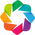

Scatter

Online example: https://holoviews.org/reference/elements/bokeh/Scatter.html

-------------
Style Options
-------------

	alpha, angle, cmap, color, fill_alpha, fill_color, hit_dilation, hover_alpha, hover_color, hover_fill_alpha, hover_fill_color, hover_line_alpha, hover_line_cap, hover_line_color, hover_line_dash, hover_line_dash_offset, hover_line_join, hover_line_width, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, marker, muted, muted_alpha, muted_color, muted_fill_alpha, muted_fill_color, muted_line_alpha, muted_line_cap, muted_line_color, muted_line_dash, muted_line_dash_offset, muted_line_join, muted_line_width, nonselection_alpha, nonselection_color, nonselection_fill_alpha, nonselection_fill_color, nonselection_line_alpha, nonselection_line_cap, nonselection_line_color, nonselection_line_dash, nonselection_line_dash_offset, nonselection_line_join, nonselection_line_width, palette, radius, radius_dimension, selection_alpha, selec

In [5]:
hv.extension('bokeh')
hv.help(hv.Scatter)